#Creazione classe dataset

In [2]:
import torch
import numpy as np
import pandas as pd
import fiona
import os

!pip install rasterio
!pip install geopandas
!pip install matplotlib

import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive', force_remount=True)
percorso =  "/content/drive/MyDrive/Progetto_laboratorio"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 69.3 MB/s eta 0:00:00
Mounted at /content/drive


In [12]:
from torch.utils.data import Dataset
import json
from shapely.geometry import shape
from rasterio.features import rasterize

class Dataset(Dataset):
  def __init__(self,root,transform = None):
    self.root = root  #directory radice
    self.transform = transform
    self.zones = self.load_zones()


  def load_zones(self):
    zones = {}       #dizionario dove ad ogni chiave corrispondono
    #itero attraverso le cartelle per trovare percorsi delle immagini
    for zone in os.listdir(self.root):
      zone_path = os.path.join(self.root,zone)
      if os.path.isdir(zone_path):
        zones[zone] = self.load_images_and_labels(zone_path)
    return zones

  def load_images_and_labels(self,zone_path):
    image_label_pairs = []
    if os.path.isdir(zone_path):
      images_dir = os.path.join(zone_path, 'images_masked')     #directory con immagini
      labels_dir = os.path.join(zone_path, 'labels_match')      #directory con labels
      if os.path.exists(images_dir) and os.path.exists(labels_dir):
        for image_file in os.listdir(images_dir):
          if (image_file.endswith('.tif')):
            image_path = os.path.join(images_dir,image_file)
            label_file = os.path.splitext(image_file)[0] + '_Buildings.geojson'
            label_path = os.path.join(labels_dir,label_file)

            if os.path.exists(label_path):
              image_label_pairs.append((image_path,label_path))
    return image_label_pairs


  def __len__(self):
    return sum(len(pairs) for pairs in self.zones.values())


  def __getitem__(self,idx):
    image_mask_list = []
    for x in self.zones[idx]:
      image_path,label_path = x

      with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32)
        out_shape = (src.height,src.width)
        transform = src.transform

        with open(label_path) as label:
          geojson = json.load(label)

        if 'features' in geojson and len(geojson['features']) > 0:
          gdf = gpd.GeoDataFrame.from_features(geojson['features'])
          if not gdf.empty and gdf.geometry.notnull().any():

            mask = rasterize( [(geom,1) for geom in gdf.geometry], out_shape=out_shape,transform=transform,fill=0,dtype='uint8')
          else:
            mask = np.zeros(out_shape,dtype='uint8')
        else:
          mask = np.zeros(out_shape,dtype='uint8')

        if self.transform:
          image = self.transform(image)
          mask = self.tranform(mask)

        image_mask_list.append((image,mask))
    return image_mask_list

In [ ]:
train_dataset = Dataset("/content/drive/MyDrive/Progetto_laboratorio/Dataset/train")
test_dataset = Dataset("/content/drive/MyDrive/Progetto_laboratorio/Dataset/test")
val_dataset = Dataset("/content/drive/MyDrive/Progetto_laboratorio/Dataset/validation")
dataset_test_raster = {}
dataset_train_raster = {}
dataset_val_raster = {}
key = next(iter(test_dataset.zones))
print(test_dataset.zones)
for zone in train_dataset.zones:
  dataset_train_raster[zone] = train_dataset[zone]
for zone in test_dataset.zones:
  dataset_test_raster[zone] = test_dataset[zone]
for zone in val_dataset.zones:
  dataset_val_raster[zone] = val_dataset[zone]

In [15]:
from rasterio.plot import show
for zone in train_dataset.zones:
  arr = dataset_train_raster[zone][0][1]
  print(np.sum(arr==1))

# Visualizza l'immagine e le etichette rasterizzate
  fig, ax = plt.subplots()
  show(dataset_train_raster[zone][0][0].astype(np.int32), ax=ax, title='Immagine con Etichette Rasterizzate')
  ax.imshow(arr, cmap='Reds', alpha=0.5)
  plt.show()

([array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,  64.,  61., ..., 132., 110.,   0.],
        [  0.,  70.,  62., ..., 156., 136.,   0.],
        ...,
        [  0.,  66.,  58., ...,  60.,  65.,   0.],
        [  0.,  62.,  58., ...,  54.,  62.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,  69.,  67., ..., 116., 102.,   0.],
        [  0.,  73.,  69., ..., 136., 120.,   0.],
        ...,
        [  0.,  73.,  67., ...,  63.,  65.,   0.],
        [  0.,  69.,  66., ...,  59.,  64.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,  40.,  39., ...,  88.,  72.,   0.],
        [  0.,  44.,  41., ..., 104.,  92.,   0.],
        ...,
        [  0.,  36.,  32., ...,  34.,  38.,   0.],
        [  0.,  35.,  33., ...,  29.,  37.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0

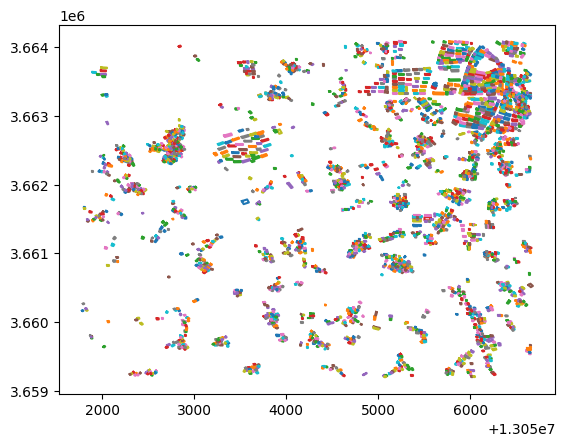

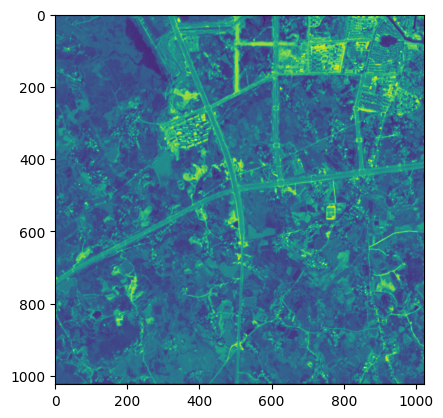

In [ ]:
import matplotlib.pyplot as plt
key = next(iter(test_dataset.zones))
print(dataset_test_raster[key])
def load_geojson(geojson_path):
    with open(geojson_path) as f:
        geojson = json.load(f)
    return geojson

def plot_geometries(geojson):
  geometries = [shape(feature['geometry']) for feature in geojson['features']]
  for geom in geometries:
    x, y = geom.exterior.xy
    plt.plot(x, y)
  plt.show()

def plot_raster(image_path):
  with rasterio.open(image_path) as src:
    image = src.read(2)
    plt.imshow(image)
  plt.show()

geojson_path = test_dataset.zones[key][0][1]
geojson = load_geojson(geojson_path)
plot_geometries(geojson)

# Carica e visualizza l'immagine raster
image_path = test_dataset.zones[key][0][0]
plot_raster(image_path)